## **Serg and Polina V1.1.20**

**Credit Scoring**

Прогнозирование вероятности дефолта заемщика

Представьте, что вы работаете стажером в отделении регионального банка. Вы все также делаете запросы к базам данных и строите отчеты. Вы поймали себя на мысли, что представляли работу дата-саентиста совсем иначе…

И вот сегодня, когда вы уже были на пороге отчаяния, ваш начальник пришел к вам с долгожданной новостью. Будем строить модель!

“Отлично,” – думаете вы, – “наконец-то смогу заняться настоящей работой!”

Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Условия соревнования:
Данное соревнование является бессрочным и доступно для всех потоков.

Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

Тестовая выборка представлена в ЛидерБорде целиком.

Поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку).

Разрешено использовать любые ML алгоритмы и библиотеки (кроме DL).

Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

Credit Scoring
Прогнозирование вероятности дефолта заемщика

In [17]:
import pandas as pd
import numpy as np
from pandas import Series
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, plot_confusion_matrix, accuracy_score, recall_score, precision_score


%matplotlib inline

# 0. Подготовим функции и классы для дальнейшей работы

In [ ]:
# класс для построения визуализация для числового признака и нахождения выбросов.

class AnalyzNumCol():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))
        
        fig.suptitle('Histogram, QQ-plot and boxplot for {0} '.format(column))
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', 
                 rwidth = 0.8, color = 'red')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 
        
        
        
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def emission_limits(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, log = False): 
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.emission_limits(log)
        return len(data[data < minb])+ len(data[data > maxb])

    
# класс логарифмирования признака
    
class LogDf(): 
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 
    
# метрика для оценки модели

class MatrixModel(): 
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', 
                    cmap= 'Pastel1',
                    cbar = False, xticklabels = ['Дефолт','Не дефолт'], 
                    yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)

        plt.show()

# 1. Импортируем данные

In [ ]:
data_directory = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [ ]:
print('данные для обучения')
data_train.info()

#### Вывод

пропуски представлены в столбце 'education' и составляют около 0.4%


In [ ]:
# зафиксируем константы
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [ ]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['Train'] = 1 # помечаем где у нас трейн
data_test['Train'] = 0 # помечаем где у нас тест

data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.isna().sum()

заполним пропуски самым частым значением

In [ ]:
data['education'] = data['education'].fillna(data.education.mode()[0])

Описания полей датасета

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту 

В тренировочном наборе 73492 записей, в тестовой - 36178. Всего 19 переменных (18 признаков + целевая).

In [ ]:
# исправим дату
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')

# 2. Предварительный анализ данных

In [ ]:
data.describe()

In [ ]:
data.describe(include = 'object')

In [ ]:
# переведем данные в цифровой формат

label_encoder = LabelEncoder()

for column in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    data[column] = label_encoder.fit_transform(data[column])

In [ ]:
data.describe()

In [ ]:
fig = px.parallel_coordinates(data[data.Train == 1], 
                              dimensions=['default', 'education', 'sex', 'age', 
                                          'car', 'car_type', 
                                          'decline_app_cnt', 'good_work', 
                                          'score_bki', 'bki_request_cnt'], 
                              color='default')
fig.show()

In [ ]:
fig = px.parallel_coordinates(data[data.Train == 1], 
                              dimensions=['default', 'region_rating', 
                                          'home_address', 'work_address', 'income', 
                                          'sna', 'first_time', 'foreign_passport'], 
                              color='default')
fig.show()

#### Вывод

С 90% вероятностью можно сказать что дефолт наступит в следующем случае:

1. Дефолту подвержены люди всех видов образования, пола, наличия автомобиля и автомобиля иностранного производства, категоризатор домашнего адреса, категоризатор рабочего адреса, наличие загранпаспорта, давность наличия информации о заемщике,region_rating.
2. На невозврат долга существенное влияние оказывают следующие факторы:

    * количество отказанных прошлых заявок. При этом если количество откланенных заявок выше 15 то наблюдается явный эффект организации возврата;
    * скоринговый балл по данным из БКИ. Находится ниже 0.2;
    * если количество запросов в БКИ не большое, то вероятность дефолта высокая;
    * люди с низким доходом, до 0.4-0.5 М.

С 90% вероятностью можно сказать, что наступление дефолта равно 0:

1. расширился возраст т.е. пенсионеры за 70 лучше платят, увеличелось число отказов и количество запросов БКИ, однозначно выросли доходы.

Проверим как на возврат влияет день месяца и месяц

In [ ]:
data['day'] = data['app_date'].dt.day
data['month'] = data['app_date'].dt.month

In [ ]:
fig = px.parallel_coordinates(data[data.Train == 1], 
                              dimensions=['default', 'day', 'month'], 
                              color='default')
fig.show()

На выдачу кредитов может влиять количество заявок на кредит

In [ ]:
dates = data.app_date.value_counts()
data['q_app'] = data.app_date.apply(lambda x: dates[x])

Вывод

Дни месяца и номер месяца не играет существенной роли при определении дефолта. Однако стоит отметить, что время играет важную роль в различных скоринговых моделях, то создадим новый новый признак дельту от конца 2020 года

In [ ]:
NY_2020 = pd.to_datetime('31/12/2020')
data['delta_time'] = (NY_2020 - data['app_date']).dt.days
data[data.month == 1]['delta_time'].head()

Вывод

Из данных удалим признаки app_date, month, day

In [ ]:
data.drop(['day', 'app_date', 'month'],  axis = 1, inplace = True)

# 3. Обработка признаков в данных

In [ ]:
cols = data.columns
for col in cols:
    if data[col].dtype != 'O' and len(data[col].unique())<=20:
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))
    else:
        print('Числовой признак {}'.format(col))

## Age

In [ ]:
age = AnalyzNumCol(data[data.Train == 1], 'age')
age.show_plots()
age.show_plots(log = True)

**Вывод**

Признак распределен нормально. И выбросы отсутсвуют. Стоит отметить, что после логорифмирования признак к стал стремиться еще больше к нормальности.

Таким образом логорифмируем признак age

In [ ]:
data['age'] = np.log(data['age'] + 1)

## decline_app_cnt

In [ ]:
decline_app_cnt = AnalyzNumCol(data[data.Train == 1], 'decline_app_cnt')
decline_app_cnt.show_plots()
decline_app_cnt.show_plots(log = True)

**Вывод**

В признаке decline_app_cnt наблюдается сильное смещение. Применение логорифмирования улучшило данный призна

Просмотрим выбросы

In [ ]:
print('Суммарное количество выбросов для decline_app_cnt: ', 
      decline_app_cnt.amount_emissions())
print('Суммарное количество выбросов для log(decline_app_cnt): ', 
      decline_app_cnt.amount_emissions(log = True))

In [ ]:
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)

**Вывод**

Выбросов большое количество, на данном этапе оставим их в работе

Так как в основе данного признака лежит отказ в кредитовании, то можно создать либо бинарный признак был отказ или не был отказ или категориальный признак: не было отказа (0), 1 отказ (1) и 2 и более отказов (2). Исходя из предыдущего анализа добавим бинарный признак

In [ ]:
data['decline_yes'] = data['decline_app_cnt'].apply(lambda x: 0 if x < 1 else 1)

## score_bki

In [ ]:
score_bki = AnalyzNumCol(data[data.Train == 1], 'score_bki')
score_bki.show_plots()
score_bki.show_plots(log=True)

**Вывод**

Признак нормально распределен но у него большое количество выбрасов. ПРосмотрим количество выбросов

In [ ]:
print('Суммарное количество выбросов для score_bki: ', 
      score_bki.amount_emissions())
print('Суммарное количество выбросов для log(score_bki): ', 
      score_bki.amount_emissions(log = True))

**Вывод** 
Признак логорифмировать не будем, удалать выбросы не будем т.к. их небольшое количество

## bki_request_cnt

In [ ]:
bki_request_cnt = AnalyzNumCol(data[data.Train == 1], 'bki_request_cnt')
bki_request_cnt.show_plots()
bki_request_cnt.show_plots(log = True)

**Вывод**

При логорифмировании критерий становиться ближе к нормальному распределению. У нас есть выбросы, которые необходимо дополнительно обработать

In [ ]:
print('Суммарное количество выбросов для bki_request_cnt: ', 
      bki_request_cnt.amount_emissions())
print('Суммарное количество выбросов для log(bki_request_cnt): ', 
      bki_request_cnt.amount_emissions(log = True))

In [ ]:
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)

После логорифмирования количество выбросов существенно уменьшилось.

Также благодаря ранее сделанному анализу можно добавть бинарный признак до 10 запросов и более (в итоге признак не подешел)

## income

In [ ]:
income = AnalyzNumCol(data[data.Train == 1], 'income')
income.show_plots()
income.show_plots(log = True)

**Вывод** 
логорифмирование существенно улучшело распределение признака, прологорифмируем признак и проверем количество пропусков

In [ ]:
print('Суммарное количество выбросов для income: ', 
      income.amount_emissions())
print('Суммарное количество выбросов для log(income): ', 
      income.amount_emissions(log = True))

Выбросы удaлять пока не будем.

In [ ]:
data['income'] = np.log(data['income'] + 1)

## delta_time

In [ ]:
delta_time = AnalyzNumCol(data[data.Train == 1], 'delta_time')
delta_time.show_plots()
delta_time.show_plots(log = True)

Логорифмирование никак не повлияли на признак, выбросов у признака нет

## q_app

In [ ]:
q_app = AnalyzNumCol(data[data.Train == 1], 'q_app')
q_app.show_plots()
q_app.show_plots(log = True)

критерий не стоит логорифмировать

Выделим поля с числовыми, бинарными и категориальными данными

In [ ]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 
            'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 
            'income', 'q_app', 'delta_time']

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'plasma')

Вывод

таким образом созданный признак имеет высокий коэффициент корреляции, признак bki_request_cnt_10 удаляем

In [ ]:
imp_num = Series(f_classif(data[data.Train == 1].drop(['Train', 'default'], axis = 1), data[data.Train == 1]['default'])[0], index = data.drop(['Train', 'default'], axis = 1).columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# 4. Анализ значимости признаков, поиски интересностей

In [ ]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать,
                      # по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)

# data = df_train.copy()

In [ ]:
#визуализация пропусков
# fig, ax = plt.subplots(figsize=(20,12))
# sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [1]:
def preproc_education_na_df_change_to_mode(df):
    # fill null in education
    most_common = df['education'].mode()
    df['education'].fillna(most_common[0], inplace=True)
    return df


def preproc_education_na_df_delete(df):
    df.dropna(axis=0, inplace=True)
    return df

In [ ]:
# пропуски только в education, удаляем
# data.dropna(axis=0, inplace=True)

# заменяем пропуски в education на самое частое значение
data = preproc_education_na_df_change_to_mode(data)

## Рассмотрение числовых, бинарных и категориальных признаков

In [ ]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport' ]
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

In [ ]:
"""Проверяет, совпадает ли множество категорий в тестовой и учебной выборках"""


def check_categories_in_dfs(c_cols, b_cols):    
    err=0
    for col in c_cols:
        if data[col].nunique() != df_test[col].nunique():
            print(col, data[col].unique(), 'vs.', df_test[col].unique())
            err += 1
    for col in b_cols:
        if data[col].nunique() != df_test[col].nunique():
            print(col, data[col].unique(), 'vs.', df_test[col].unique())
            err += 1
    if err==0:
        print('Категории в учебной и тестовой выборках идентичны')

In [ ]:
check_categories_in_dfs(cat_cols, bin_cols)

## Генерируем новые признаки

In [ ]:
# давность подачи заявки в днях
data['days_to_app'] = (pd.to_datetime(datetime.now()) 
                       - pd.to_datetime(data['app_date'])).apply(lambda x: x.days)
min_val = data['days_to_app'].min()
data['days_to_app'] = data['days_to_app'].apply(lambda x: x-min_val)
# месяц подачи заявки
data['month_app'] = pd.to_datetime(data['app_date']).apply(lambda x: x.month)

In [ ]:
data['days_to_app'].min(), data['days_to_app'].max()

В датасете представлены данные за 120 дней
Это данные за 4 месяца - с января по апрель

In [ ]:
data['month_app'].value_counts()

In [ ]:
if 'days_to_app' not in num_cols:
    num_cols.append('days_to_app')


if 'month_app' not in cat_cols:
    cat_cols.append('month_app')
        
num_cols , cat_cols

In [ ]:
data[num_cols].boxplot()

In [3]:
def has_outliers(column, df):

    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr
    
#     print('---------------------------')
#     print('Границы выбросов: ', lower_bound, ', ', upper_bound)
#     print('---------------------------')

    ok_values_cnt = (df[column].loc[df[column].between(
        lower_bound, upper_bound)]).count()
    outliers_cnt = df[column].count() - ok_values_cnt

    print('Количество выбросов', outliers_cnt)
    print('---------------------------')

In [ ]:
for col in num_cols:
    print(col.upper())
    has_outliers(col, data)
    print(col.upper(), 'LOG')
    has_outliers(col, np.log1p(data[num_cols]))

In [4]:
def lookup_on_num_column(df, col_name):
    plt.figure(figsize=(6,4))
    
    sns.distplot(df[col_name], kde = False, rug=False)
    
    plt.show()
    #sns.histplot(data=df[col_name])
    sns.distplot(np.log1p(df[col_name]), kde = False, rug=False)



In [ ]:
for col in num_cols:
    lookup_on_num_column(data, col)

## **Выводы о распределениях  по графикам:**

age - скорее лог-нормальное, признак логарифмируем

decline_app_cnt - почти все значения сосредоточены в нуле, распределение скорее лог-нормальное, выбросов меньше, когда признак логарифмируем, так и поступим

score_bki - нормальное распределение, выбросов не много

bki_request_cnt - скорее лог-нормальное, признак логарифмируем

income - лог-нормальное, выбросов много, пока все оставляем, признак логарифмируем

days_to_app - скорее равномерное с учетом "сезонных" колебаний


# Логарифмируем выбранные числовые признаки

In [ ]:
cols_to_log1p = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
data[cols_to_log1p].apply(lambda x: np.log1p(x))

In [5]:
def find_lower_upper_bound(column, df):
    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr
    return lower_bound, upper_bound

'''return new df without outliers in column'''


def del_outliers_for_column(column, lower_b, upper_b, df):

    df_no_outliers = df.loc[df[column].between(lower_b, upper_b)]
    
    return df_no_outliers


def delete_outliers(df):

    cols_to_del_outliers = ['score_bki', 'bki_request_cnt', 'income']

    lb_score, ub_score = find_lower_upper_bound('score_bki', df)
    lb_bki_request_cnt, ub_bki_request_cnt = find_lower_upper_bound('bki_request_cnt', df)
    lb_income, ub_income = find_lower_upper_bound('income', df)

    df = del_outliers_for_column('score_bki', lb_score, ub_score, df)
    df = del_outliers_for_column('bki_request_cnt', lb_bki_request_cnt, ub_bki_request_cnt, df)
    df = del_outliers_for_column('income', lb_income, ub_income, df)
    
    return df




# Посмотрим интересные истории распределения с учетом целевого default

In [6]:
def boxplot_for_numcols(df, col_name, hue_col=None):
    plt.figure()
    # sns.boxplot(x=df[hue_col], y=np.log1p(np.abs(df[col_name])))
    sns.boxplot(x=df[hue_col], y=df[col_name])

    plt.show

In [ ]:
for column in num_cols:
    boxplot_for_numcols(data, column, 'default')

In [ ]:
sns.countplot(x='month_app', data=data, hue='default')

судя по распределнию 

## выводы о наблюдениях

средний возраст дефолта меньше, чем недефолта

значение skore_bki выше у дефолта, чем у недефолта 

bki_request_cnt больше у дефолта чем у недефолта

days_to_app (давность подачи заявки) больше у недефолта

In [ ]:
data.where(data['decline_app_cnt']==0).groupby(by='default')['decline_app_cnt'].sum()

In [ ]:
data.where(data['decline_app_cnt']>0).groupby(by='default')['decline_app_cnt'].sum()

In [ ]:
data.groupby('default')['income'].median()

## Корреляция между числовыми признаками

In [ ]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

##  Вывод про корреляцию
Видим, что абсолютные значения корреляции не большие (макс - 0.19) - т.е признаки можем считать независимыми, и добавлять их в модель все

0.17 - после удаления выбросов в признаках income, score_bki, bki_request_cnt

## Построение ANOVA-f метрики для оценки значимости числовых признаков

In [ ]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Работа с бинарными признаками - перекодировка в числовые (0, 1)

In [ ]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [ ]:
data.sample(5)

### Категориальные признаки тоже надо сделать числовыми

In [ ]:
cat_cols

In [ ]:
# data.dropna(inplace=True)
#data['education'] = data['education'].apply(lambda x: "SCH" if x==nan else x)
print(data['education'].unique())
data['education'] = label_encoder.fit_transform(data['education'])
print(dict(enumerate(label_encoder.classes_)))

In [ ]:
imp_cat = Series(mutual_info_classif(
    data[bin_cols + cat_cols], data['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [ ]:
# fig = px.parallel_coordinates(data, dimensions=['decline_app_cnt',
#         'default'], color='default')
# fig.show()

In [ ]:
# fig = px.parallel_coordinates(data, dimensions=['sna',
#         'default'], color='default')
# fig.show()

# Посмотрели всякое разное, теперь пора к обработке данных и модели
## Начинаем с начала

## Общая функция обработки данных

In [7]:
def proc_data(df, bin_cols, cat_cols, num_cols):
    
    #---избавляемся от NAN
    df = preproc_education_na_df_change_to_mode(df)
    #data = preproc_education_na_df_deleteproc(data)
    #---------------------
    bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport' ]
    cat_cols = ['education', 'region_rating', 'home_address', 
                'work_address', 'sna', 'first_time']
    num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

    #---добавили новые признаки---
    # давность подачи заявки в днях
    df['days_to_app'] = (pd.to_datetime(datetime.now()) 
                         - pd.to_datetime(df['app_date'])).apply(lambda x: x.days)
    min_val = df['days_to_app'].min()
    df['days_to_app'] = df['days_to_app'].apply(lambda x: x-min_val)
    # месяц подачи заявки
    data['month_app'] = pd.to_datetime(data['app_date']).apply(lambda x: x.month)
    if 'days_to_app' not in num_cols:
        num_cols.append('days_to_app')
        
    if 'month_app' not in cat_cols:
        cat_cols.append('month_app')
     
    df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
    dates = df['app_date'].value_counts()
    # q_app - количество заявок на кредит в тот же день
    df['q_app'] = df.app_date.apply(lambda x: dates[x])
    if 'q_app' not in num_cols:
        num_cols.append('q_app')

    #----------------------

    
    #---прологарифмировали некоторые признаки
    cols_to_log1p = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
    data[cols_to_log1p].apply(lambda x: np.log1p(x))
    #-----------------
    
    #---бинарные - в числовые
    label_encoder = LabelEncoder()
    for column in bin_cols:
        df[column] = label_encoder.fit_transform(df[column])
    #---строковые категориальные в числовые    
    df['education'] = label_encoder.fit_transform(df['education'])
    df['region_rating'] = label_encoder.fit_transform(df['region_rating'])


    #---dummies для категорильных
    cols_to_dummies = cat_cols
    df = pd.get_dummies(df, columns=cols_to_dummies)


    #---удаление ненужных признаков 
    df.drop('client_id', axis=1, inplace=True)
    df.drop('app_date', axis=1, inplace=True)
    
    return df, bin_cols, cat_cols, num_cols

## Методы для финальной обработки и разбиения всего сета на тренировочные и тестовые данные

In [8]:
"""делает из df массив, где вначале записаны 
числовые данные, дальше бинарные, потом категориальные
такой порядок нужен, чтоб удобно применять StandardScaler
df должен быть без признаков default, sample"""

def combine_df_in_ndarray(df, n_cols, b_cols):
    #print(len(num_cols), num_cols)
    #print(len(bin_cols), bin_cols)
    #print(len(cat_cols), cat_cols)
    
    #print(num_cols+bin_cols)
    other_cols = df.columns.to_list()
    #print('other_cols')
    #print(other_cols)

    for x in n_cols+b_cols:
    #    print(x)
        other_cols.remove(x)
    
    #print(len(df.columns)-len(num_cols)-len(bin_cols), len(other_cols))
    #print(other_cols)
    
        
    X = np.hstack([df[n_cols].values, df[b_cols].values, df[other_cols].values])
    #print(X.shape)
    return X
    

In [9]:
def create_orig_test_from_preproced_df(df, num_columns, bin_columns):
    # выделенеи TEST, которые были из файла test.csv
    test_data_df = df.query('sample == 0').drop(['sample'], axis=1)
    test_data_df.drop('default', axis=1, inplace=True)
    X_test_ORIG = combine_df_in_ndarray(test_data_df, num_columns, bin_columns)
    return X_test_ORIG

In [10]:
def create_train_splited_on4(df, num_columns, bin_columns):
    # Выделяем TRAIN выборку
    train_data_df = df.query('sample == 1').drop(['sample'], axis=1)


    # Обработка TRAIN
    # убираем столбцы default
    X_df = train_data_df.drop(['default'], axis=1)

    # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
    # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
    X = combine_df_in_ndarray(X_df, num_columns, bin_columns)
    y = train_data_df['default'].values            # наш таргет


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

In [11]:
def create_train_splited_on4_balanced_by_def1(df, num_columns, bin_columns):
    ## experiment cut def=0 to size def=1
    # Делим выборку назад на учебную и тестовую, согласно признаку sample
    train_data_df_EX = df.query('sample == 1').drop(['sample'], axis=1)


    size1 = len(train_data_df_EX[train_data_df_EX['default']==1])
    rez0 = train_data_df_EX[train_data_df_EX['default']==0][:size1]
    rez1 = train_data_df_EX[train_data_df_EX['default']==1]
    rezX = rez0.append(rez1)


    # убираем столбцы default
    X_df_EX = rezX.drop(['default'], axis=1)

    # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
    # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
    X_EX = combine_df_in_ndarray(X_df_EX, num_columns, bin_columns)
    y_EX = rezX['default'].values 


    X_train, X_test, y_train, y_test = train_test_split(X_EX, y_EX, test_size=0.20, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

In [12]:
def create_train_splited_on4_balanced_by_def0(df, num_columns, bin_columns):
    # experiment добавим несклько раз дубли для default=1
    # Делим выборку назад на учебную и тестовую, согласно признаку sample
    train_data_df_EX2 = df.query('sample == 1').drop(['sample'], axis=1)

    rez1 = train_data_df_EX2[train_data_df_EX2['default']==1]
    train_data_df_EX2 = train_data_df_EX2.append(rez1)

    train_data_df_EX2 = train_data_df_EX2.append(rez1)

    # убираем столбцы default
    X_df_EX2 = train_data_df_EX2.drop(['default'], axis=1)

    # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
    # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
    X_EX2 = combine_df_in_ndarray(X_df_EX2, num_columns, bin_columns)
    y_EX2 = train_data_df_EX2['default'].values 


    X_train, X_test, y_train, y_test = train_test_split(X_EX2, y_EX2, test_size=0.20, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

## Стандартизация числовых признаков: отдельно тренировочной, отдельно тестовой выборок

In [13]:
def scale_numeric_data(X_train, X_test1, X_test2, num_col_cnt):
    scaler = StandardScaler()

    X_train[:,:num_col_cnt] = scaler.fit_transform(X_train[:,:num_col_cnt]).copy()

    X_test1[:,:num_col_cnt] = scaler.transform(X_test[:,:num_col_cnt])
    X_test2[:,:num_col_cnt] = scaler.transform(X_test_ORIG[:,:num_col_cnt])
    return X_train, X_test1, X_test2

## Вывод метрик

In [14]:
def print_metrics(model, X_test, y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    Sp = tn / (tn+fp)
    # Se = tp / (tp+fn)
    # Re = tp / (tp+fn)
    # Pr = tp / (tp+fp)
    # Ac = (tn+tp) / (tp+tn+fp+fn)
    # print('Acc=%.4f.  Pr=%.4f.  Re=%.4f.  Se=%.4f.  Sp=%.4f' % (Ac , Pr , Re , Se , Sp))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('Precision: %.4f' % precision_score(y_test, y_pred))
    print('Recall: %.4f' % recall_score(y_test, y_pred))
    print('Specifity: %.4f' % Sp)
    print('F1: %.4f' % f1_score(y_test, y_pred))
    print('tn fp fn tp: ', tn, fp, fn, tp)
    plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
    plt.show()
    roc_auc = print_roc_auc(model, X_test, y_test)
    print('roc_auc: ', roc_auc)
    return

#построение  ROC 
def print_roc_auc(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    probs = probs[:,1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure(figsize=(3,3))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    return roc_auc

# Функция подбора оптимальных параметров

In [15]:
def find_best_f1_score_model_hyperparams(X_train, y_train):
    # запускаем GridSearch на небольшом кол-ве итераций max_iter=50 
    # и с достаточно большой дельтой останова tol1e-3
    # чтобы получить оптимальные параметры модели в первом приближении


    model = LogisticRegression(random_state=42)

    iter_ = 50
    epsilon_stop = 1e-3

    param_grid = [
        {'penalty': ['l1'], 
         'solver': ['liblinear', 'lbfgs'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_],
         'tol':[epsilon_stop]},
        {'penalty': ['l2'], 
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_],
         'tol':[epsilon_stop]},
        {'penalty': ['none'], 
         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_],
         'tol':[epsilon_stop]},
    ]

    gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
    gridsearch.fit(X_train, y_train)

    best_model = gridsearch.best_estimator_
    ##печатаем параметры
    best_parameters = model.get_params()
    for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    
    return best_model


# Весь флоу

In [27]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')

# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать,
                      # по этому пока просто заполняем нулями
# объединили сет
data = df_test.append(df_train, sort=False).reset_index(drop=True)
# предобработка
bin_cols = []
cat_cols = []
num_cols = []

data, bin_cols, cat_cols, num_cols = proc_data(data, bin_cols, cat_cols, num_cols)

# ОПЦИОНАЛЬНО удалили выбросы
#data = delete_outliers(data)

# блок про удаление некоторых признаков из рассмотрения
#data.info()
# print(num_cols)
# data.drop('sex', axis=1, inplace=True)
# data.drop('age', axis=1, inplace=True)
# data.drop('car', axis=1, inplace=True)
# #data.drop('days_to_app', axis=1, inplace=True)
# #data.drop('good_work', axis=1, inplace=True)
# data.drop('month_app_1', axis=1, inplace=True)
# data.drop('month_app_2', axis=1, inplace=True)
# data.drop('month_app_3', axis=1, inplace=True)
# data.drop('month_app_4', axis=1, inplace=True)
# #data.info()
# bin_cols.remove('sex')
# num_cols.remove('age')
# bin_cols.remove('car')
# #num_cols.remove('days_to_app')
# #bin_cols.remove('good_work')


# работа с моделью
X_test_ORIG = create_orig_test_from_preproced_df(data, num_cols, bin_cols)


# базовое разделение
X_train, X_test, y_train, y_test = create_train_splited_on4(data, num_cols, bin_cols)
# разделение с учетом сбалансированности (меньшая размерность датасета)
# X_train, X_test, y_train, y_test = create_train_splited_on4_balanced_by_def1(
#     data, num_cols, bin_cols)
# разделение с учетом сбалансированности (добавим несколько дублей def=1)
# X_train, X_test, y_train, y_test = create_train_splited_on4_balanced_by_def0(
#     data, num_cols, bin_cols)


# стандартизация числовых признаков
l = len(num_cols)
scale_numeric_data(X_train, X_test, X_test_ORIG, l)

model = LogisticRegression( max_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_metrics(model, X_test, y_test, y_pred)


SyntaxError: invalid syntax (<ipython-input-27-7284d9bc0bae>, line 48)

## Выводы 1

рассматривалось несколько вариантов подготовки данных, сравнивались метрики ROC-AUC. Здесь более детально описано лучших представителей.

Базовая модель с базовой подготовкой данных:

хоть Roc-auc имеет хорошее значение, confusion-матрица плохая - мы часто даем кредит тем, кто в итоге его не погасит (FN = 1788)

* Accuracy: 0.8743
* Precision: 0.3670
* Recall: 0.0219
* Specifity: 0.9947
* F1: 0.0413
* tn fp fn tp:  12864 69 1787 40
* roc_auc:  0.7429367667331498




Модель, в которую не добавили слабо влияющие признаки (sex, age, car, month_app)
* Accuracy: 0.8751
* Precision: 0.4158
* Recall: 0.0230
* Specifity: 0.9954
* F1: 0.0436
* tn fp fn tp:  12874 59 1785 42
* roc_auc:  0.7390801677510097
Результат сабмишна 0.73615

С помощью настроки гиперпараметров удалось получить следующие метрики :
* Accuracy: 0.6698
* Precision: 0.2251
* Recall: 0.6831
* Specifity: 0.6679
* F1: 0.3387
* tn fp fn tp:  8638 4295 579 1248
* roc_auc:  0.7387158210153114

Результат сабмишна 0.73229


Среди прочих тестов - рассматривалось удаление выбросов - улучшений не было.
Добавлялись новые признаки,их значимость не была высокой, но модель те, которые остались в финальной обработке - улучшили - давность поданной заявки, месяц подачи заявки
Выборка в два способа делалась сбалансированной : удаление части данных про default=0, это привело к тому, что модель сразу давала существенно лучшую confusion-матрицу, но значение ROC существенно падало. Зато значение F1 сразу было хорошим

Дополнение тренировочной выборки копиями значение с default=1 не дало улучшения метрики, давало такую же модель с точки зрения confusion-матрицы.



# Поиск оптимальных параметров

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


	C: 1.0
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy: 0.6786
Precision: 0.6734
Recall: 0.6853
Specifity: 0.6720
F1: 0.6793
tn fp fn tp:  1268 619 586 1276


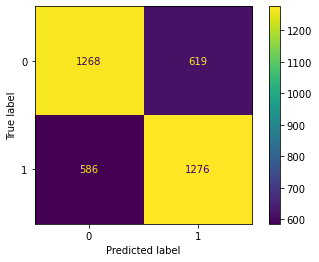

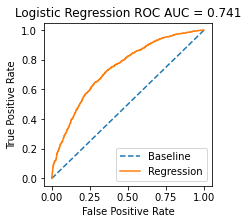

roc_auc:  0.7410824927410509


In [25]:
best_model = find_best_f1_score_model_hyperparams(X_train, y_train)
y_pred = best_model.predict(X_test)
print_metrics(best_model, X_test, y_test, y_pred)

# Выводы 2 о полученной улучшенной модели после подбора гиперпараметров с условием, что хотим максимизировать f1-скоринг

модель стала чаще отказывать надежным плательщикам - было 68 (FP) - 12865(TN), стало 4254 - 8679


модель лучше распознает "дефолтных" -было 39 (TP) - 1788(FN), стало 1243 - 584

# SUBMISSION

In [26]:

# тут массив из данных из файла test, который обрабатывался так же, как и train, 
# над ним сделалася StandardScaler.transform() по Scalerу, 
# который строился на тренировночных данных.

print(X_test_ORIG.shape)

y_pred_prob_FINAL = best_model.predict_proba(X_test_ORIG)[:,1]


data_test = pd.read_csv(DATA_DIR+'/test.csv')
submit = pd.DataFrame(data_test['client_id'])
submit['default'] = y_pred_prob_FINAL

submit.head(20)


# СОЗДАНИЕ ФАЙЛА САБМИТА
submit.to_csv('submission.csv', index=False)

(36349, 42)
